## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera calibration

Function `calibrate_camera()` returns `mtx` and `dist` for undistorting images. The chessboard images with corners are saved in `output_images/camera_calibration` folder

In [1]:
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
%matplotlib inline

def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    output_images_folder = '../output_images/camera_calibration/'

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
            # Save to folder
            output_fname = output_images_folder + fname.split('/')[-1]
            cv2.imwrite(output_fname, img)

    # It is found the grayscale calibration images are all of (720, 1280)
    gray_shape = (720, 1280)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape[::-1], None, None)
    return mtx, dist

mtx, dist = calibrate_camera()

## Undistort test images

Function `undistort()` receives an image, `mtx` and `dist`. Images in the `test_images` folder are all undistorted and saved in `output_images/undistort_images` folder

In [2]:
def undistort(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [31]:
# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
output_images_folder = '../output_images/undistort_images/'
for fname in images:
    img = cv2.imread(fname)
    dst = undistort(img)
    # Save to folder
    output_fname = output_images_folder + fname.split('/')[-1]
    cv2.imwrite(output_fname, dst)
images = glob.glob('../test_images/*.jpg')
output_images_folder = '../output_images/undistort_images/'
for fname in images:
    img = cv2.imread(fname)
    dst = undistort(img)
    # Save to folder
    output_fname = output_images_folder + fname.split('/')[-1]
    cv2.imwrite(output_fname, dst)

## Threshold binary image

Use color transform, different gradient techniques to generate a binary image.
_Note: use `plt.imread()` to load images_

(720, 1280, 3)


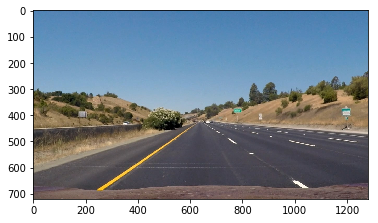

In [4]:
# Load a test image
img = plt.imread('../test_images/straight_lines1.jpg')
print(img.shape)
plt.imshow(img)

In [5]:
# Helper functions
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [6]:
def sobel_x_or_y_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Threshold on either `x` or `y` direction gradient and return a binary output
    `img` could be either color or grayscale image
    """
    min_thresh, max_thresh = thresh
    gray = np.copy(img)
    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    return binary_output

def sobel_total_mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """
    Threshold on the total gradient magnitude and return a binary output
    `img` could be either color or grayscale image
    """
    min_thresh, max_thresh = thresh
    gray = np.copy(img)
    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobel_x**2, sobel_y**2)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    return binary_output

def sobel_orientation_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Threshold on the direction of gradient directiona and return a binary output
    `img` could be either color or grayscale image
    """
    min_thresh, max_thresh = thresh
    gray = np.copy(img)
    if len(gray.shape) > 2:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_output = np.zeros_like(sobel_dir)
    binary_output[(sobel_dir >= min_thresh) & (sobel_dir <= max_thresh)] = 1
    return binary_output

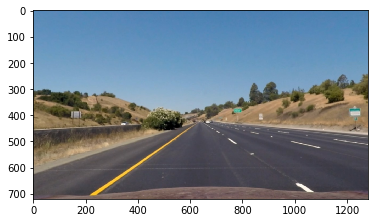

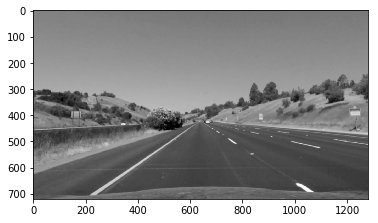

In [7]:
def prepross_img(img):
    gaussian_kernal_size = 5
    undistorted = undistort(img)
    blurred = gaussian_blur(undistorted, gaussian_kernal_size)
    return blurred

blurred = prepross_img(img)
gray = grayscale(blurred)

plt.figure()
plt.imshow(blurred)
plt.figure()
plt.imshow(gray, cmap='gray')

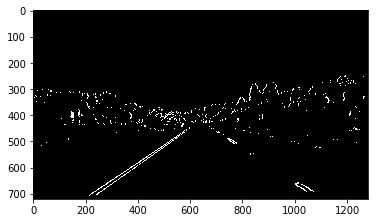

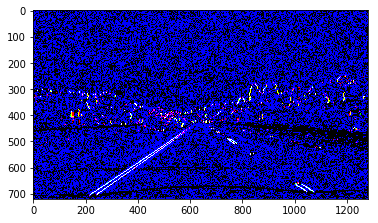

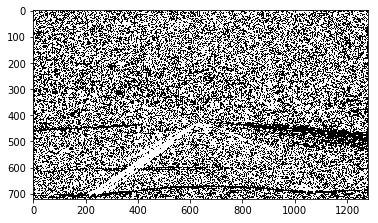

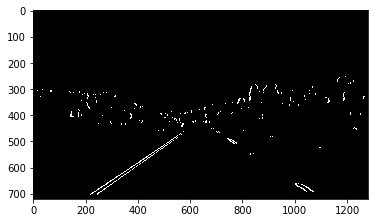

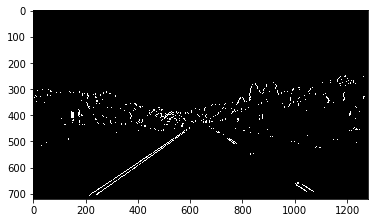

In [8]:
# Building pipeline
# Only threshold upon x direction gradient maginitude because lane lines are mostly vertical.
# Threshold on y direction gradient could give lane line shape, but it also introduces fair amount of
# noises.
# Only threshold the lower bound, becase I want to limit the potential big gradient around lane lines
# However, lower thershold should filter out surroundings, like forests.
sobel_x_kernel_size = 3
sobel_x_thresh = (50, 255)
sobel_x = sobel_x_or_y_mag_thresh(gray, 'x', sobel_x_kernel_size, sobel_x_thresh)

# Keep the threshold the same as above but increase the kernel size to smooth result.
sobel_totoal_kernel_size = 15
sobel_total_thresh = (80, 255)
sobel_total = sobel_total_mag_thresh(gray, sobel_totoal_kernel_size, sobel_total_thresh)

# From here we could potentially use Hough transform, however it is limited to staright lines only, and we want to 
# fit a second order lane curve.

# Vertical lines have orientation of 0, 0degree, horizontal lines have orientation of pi/2=1.57=90 degree. Lane lines should be around 
# 20 degree to 75 degree
sobel_dir_kernal_size = 11
sobel_dir_thresh = (0.35, 1.3)
sobel_dir = sobel_orientation_thresh(gray, sobel_dir_kernal_size, sobel_dir_thresh)

sobel_stack = np.uint8(np.dstack((sobel_x,sobel_total,sobel_dir))*255)

sobel_combined = np.zeros_like(sobel_dir)
sobel_combined[(sobel_x == 1) | ((sobel_total == 1) & (sobel_dir == 1))] = 1

plt.figure()
plt.imshow(sobel_combined,cmap='gray')
plt.imsave('../output_images/gradient_threshold/sobel_combined.jpg', sobel_combined,cmap='gray')
plt.figure()
plt.imshow(sobel_stack)
plt.imsave('../output_images/gradient_threshold/sobel_stack.jpg', sobel_stack)
plt.figure()
plt.imshow(sobel_dir, cmap='gray')
plt.imsave('../output_images/gradient_threshold/sobel_dir.jpg', sobel_dir,cmap='gray')
plt.figure()
plt.imshow(sobel_total, cmap='gray')
plt.imsave('../output_images/gradient_threshold/sobel_total.jpg', sobel_total,cmap='gray')
plt.figure()
plt.imshow(sobel_x, cmap='gray')
plt.imsave('../output_images/gradient_threshold/sobel_x.jpg', sobel_x,cmap='gray')

def gradient_threshold(img):
    # Aggregate function to put several tresholding functions together. Note the parameters are defined outside
    sobel_x = sobel_x_or_y_mag_thresh(img, 'x', sobel_x_kernel_size, sobel_x_thresh)
    sobel_total = sobel_total_mag_thresh(img, sobel_totoal_kernel_size, sobel_total_thresh)
    sobel_dir = sobel_orientation_thresh(img, sobel_dir_kernal_size, sobel_dir_thresh)
    sobel_combined = np.zeros_like(sobel_dir)
    sobel_combined[(sobel_x == 1) | ((sobel_total == 1) & (sobel_dir == 1))] = 1
    return sobel_combined

In [9]:
def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
def saturation_channel_thresh(s_channel, thresh=(0, 255)):
    min_thresh, max_thresh = thresh
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel>=min_thresh) & (s_channel<=max_thresh)] = 1
    return binary_output
def red_channel_thresh(r_channel, thresh=(0, 255)):
    min_thresh, max_thresh = thresh
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel>=min_thresh) & (r_channel<=max_thresh)] = 1
    return binary_output

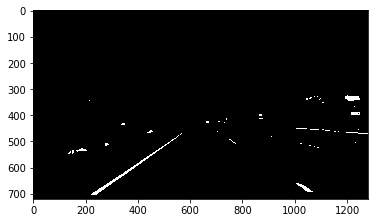

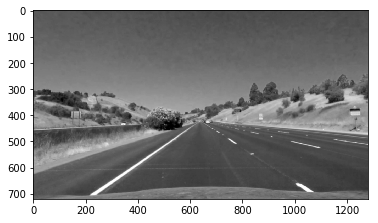

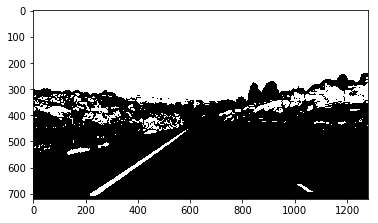

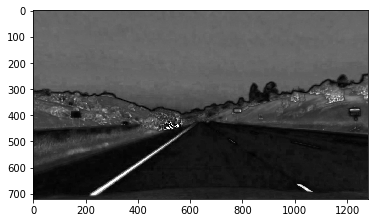

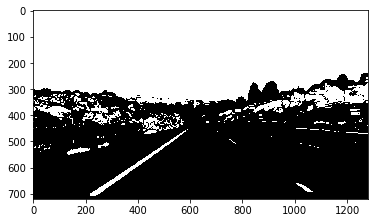

In [32]:
r_channel = blurred[:,:,0]
g_channel = blurred[:,:,1]
b_channel = blurred[:,:,2]

red_thresh = (200, 255)
r_thresholded = red_channel_thresh(r_channel, red_thresh)

plt.figure()
plt.imshow(r_thresholded, cmap='gray')
plt.imsave('../output_images/color_threshold/r_thresholded.jpg', r_thresholded,cmap='gray')
plt.figure()
plt.imshow(r_channel, cmap='gray')
# plt.figure()
# plt.imshow(g_channel, cmap='gray')
# plt.figure()
# plt.imshow(b_channel, cmap='gray')

hls = convert_hls(blurred)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

saturation_thresh = (80, 255)
s_thresholded = saturation_channel_thresh(s_channel, saturation_thresh)

plt.figure()
plt.imshow(s_thresholded, cmap='gray')
plt.imsave('../output_images/color_threshold/s_thresholded.jpg', s_thresholded,cmap='gray')
# plt.figure()
# plt.imshow(h_channel, cmap='gray')
# plt.figure()
# plt.imshow(l_channel, cmap='gray')
plt.figure()
plt.imshow(s_channel, cmap='gray')

color_combined = np.zeros_like(s_thresholded)
color_combined[(r_thresholded == 1) | (s_thresholded==1)] = 1

plt.figure()
plt.imshow(color_combined, cmap='gray')
plt.imsave('../output_images/color_threshold/color_combined.jpg', color_combined,cmap='gray')

def color_threshold(img):
    # Aggregate function to put several color threshold functions together. Note parameters are defined outside
    r_channel = img[:,:,0]
    r_thresholded = red_channel_thresh(r_channel, red_thresh)
    s_channel = convert_hls(img)[:,:,2]
    s_thresholded = saturation_channel_thresh(s_channel, saturation_thresh)
    color_combined = np.zeros_like(s_thresholded)
    color_combined[(r_thresholded == 1) | (s_thresholded==1)] = 1
    return color_combined

## Perspective transform

Bird eye view on lanes

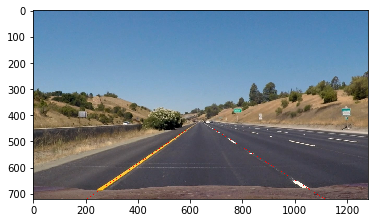

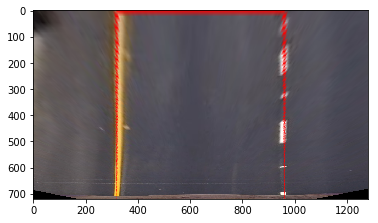

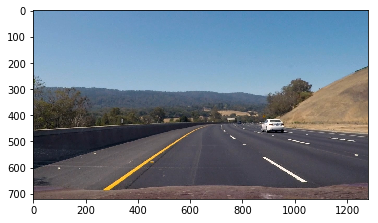

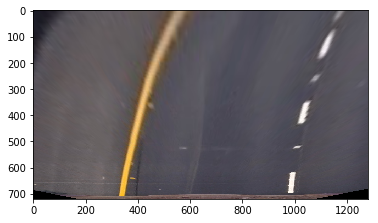

In [11]:
# Hard code perspective transform and its inverse transform

perspective_src_img = np.copy(img)
src = np.array([[(205, 720),
               (590, 453), 
               (690, 453), 
               (1115,720)]], dtype=np.float32)
src_lines = [[src[0][0:2].flatten()],
              [src[0][1:3].flatten()],
              [src[0][2:4].flatten()],
              [src[0][np.r_[-1:1]].flatten()]]

draw_lines(perspective_src_img, src_lines, thickness=1)
plt.imshow(perspective_src_img)
plt.imsave('../output_images/perspective_transform/trapezoid.jpg', perspective_src_img)

dst = np.float32([[320,720],[320,0],[960,0],[960,720]])
M = cv2.getPerspectiveTransform(src[0], dst)
M_inv = cv2.getPerspectiveTransform(dst, src[0])

warped = cv2.warpPerspective(perspective_src_img, M, perspective_src_img.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(warped)
plt.imsave('../output_images/perspective_transform/straight_lane_transformed.jpg', warped)

# test on curve lanes
curve_lane_img = plt.imread('../test_images/test3.jpg')
plt.figure()
plt.imshow(curve_lane_img)
curve_warped = cv2.warpPerspective(curve_lane_img, M, curve_lane_img.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(curve_warped)
plt.imsave('../output_images/perspective_transform/curve_lane_transformed.jpg', curve_warped)

In [12]:
# Mask is not necessary as we are doing persective transform here
def perspective_transform(img):
    # M is defined outside the function
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

## Detect lane pixels and fit lane boundaries

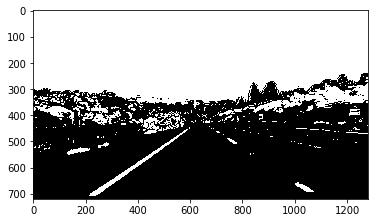

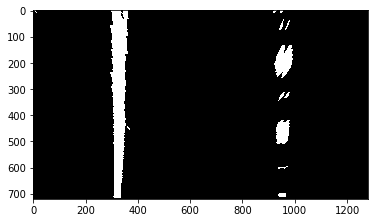

In [13]:
blurred = prepross_img(img)
grad_binary = gradient_threshold(blurred)
color_binary = color_threshold(blurred)
combined_binary = np.zeros_like(color_binary)
combined_binary[(grad_binary == 1) | (color_binary == 1)] = 1

plt.figure()
plt.imshow(combined_binary, cmap='gray')
warpped_binary = perspective_transform(combined_binary)
plt.figure()
plt.imshow(warpped_binary, cmap='gray')

In [14]:
def lane_pixel_finder_histogram_and_sliding_window(warpped_binary):
    # Use histogram peaks and sliding window to find lane pixels
    histogram = np.sum(warpped_binary[warpped_binary.shape[0]//2:,:], axis=0)

    warpped_binary_output_img = np.dstack((warpped_binary, warpped_binary, warpped_binary)) * 255

    mid_point = np.int(warpped_binary.shape[1]/2)
    leftx_current = np.argmax(histogram[:mid_point])
    rightx_current = np.argmax(histogram[mid_point:]) + mid_point

    nwindows = 12
    margin = 100
    minpix = 50

    window_height = np.int(warpped_binary.shape[0]//nwindows)
    nonzeroy, nonzerox = warpped_binary.nonzero()

    # indices for nonzeroy and nonzerox, which themselves are indices for nonzeros of warpped binary
    left_lane_indices = []
    right_lane_indices = []

    for window in range(nwindows):
        win_y_low = warpped_binary.shape[0] - (window+1)*window_height
        win_y_high = warpped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(warpped_binary_output_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(warpped_binary_output_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)

        good_left_indices = ((nonzerox>=win_xleft_low) & 
                             (nonzerox<=win_xleft_high) & 
                             (nonzeroy>=win_y_low) & 
                             (nonzeroy<=win_y_high)).nonzero()[0]
        good_right_indices =  ((nonzerox>=win_xright_low) & 
                             (nonzerox<=win_xright_high) & 
                             (nonzeroy>=win_y_low) & 
                             (nonzeroy<=win_y_high)).nonzero()[0]
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)

        if len(good_left_indices) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_indices]))
        if len(good_right_indices) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_indices]))

    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]

    return leftx, lefty, rightx, righty, warpped_binary_output_img

In [15]:
def fit_second_order_lanes(img_height, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_height-1, img_height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, left_fitx, right_fit, right_fitx, ploty

In [16]:
def lane_pixel_finder_priori(warpped_binary, left_fit, right_fit):
    margin = 100
    
    nonzeroy, nonzerox = warpped_binary.nonzero()
    
    # indices for nonzeroy and nonzerox, which themselves are indices for nonzeros of warpped binary
    left_lane_indices = (np.absolute((left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]) - nonzerox) < margin).nonzero()[0]
    right_lane_indices = (np.absolute((right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]) - nonzerox) < margin).nonzero()[0]
    
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices]
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]
    
    # searching area visualization
    warpped_binary_output_img = np.dstack((warpped_binary, warpped_binary, warpped_binary)) * 255
    mask_img = np.zeros_like(warpped_binary_output_img)
    ploty = np.linspace(0, warpped_binary.shape[0]-1, warpped_binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(mask_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(mask_img, np.int_([right_line_pts]), (0,255, 0))
    warpped_binary_output_img = cv2.addWeighted(warpped_binary_output_img, 1, mask_img, 0.3, 0)    

    return leftx, lefty, rightx, righty, warpped_binary_output_img

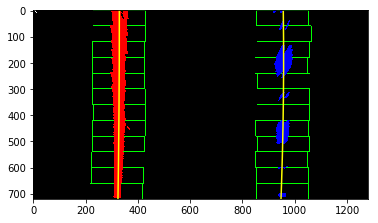

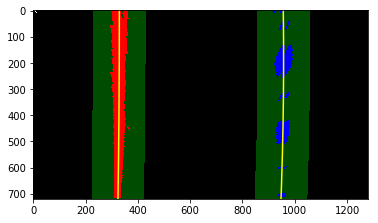

In [34]:
# Mock video processing

left_fit = None
right_fit = None

# Frame 1
leftx, lefty, rightx, righty, out_img = lane_pixel_finder_histogram_and_sliding_window(warpped_binary)

left_fit, left_fitx, right_fit, right_fitx, ploty = fit_second_order_lanes(warpped_binary.shape[0], leftx, lefty, rightx, righty)

# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.figure()
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
plt.imsave('../output_images/lane_line_pixel_finding/histogram.jpg', out_img)

# Frame 2 with valid left_fit and right_fit
leftx, lefty, rightx, righty, out_img = lane_pixel_finder_priori(warpped_binary, left_fit, right_fit)

# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.figure()
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
plt.imsave('../output_images/lane_line_pixel_finding/priori.jpg', out_img)



## Curvature and vehicle lat offset calculation

In [18]:
def get_curvature(y_value, fit, xm_per_pix, ym_per_pix):
    A = fit[0] * xm_per_pix / (ym_per_pix**2)
    B = fit[1] * xm_per_pix / ym_per_pix
    return (1+(2*A*y_value * ym_per_pix + B)**2)**1.5 / np.absolute(2*A)

In [19]:
# parameters hard coded and are from `output_images/perspective_transform/straight_lane_transformed.jpg`
ym_per_pix = 3/90 # meters per pixel in y dimension
xm_per_pix = 3.7/650 # meters per pixel in x dimension

print("left_curvature: {}".format(get_curvature(720, left_fit, xm_per_pix, ym_per_pix)))
print("right_curvature: {}".format(get_curvature(720, right_fit, xm_per_pix, ym_per_pix)))

left_curvature: 8318.919204317199
right_curvature: 2777.8101035070495


In [20]:
def get_lat_offset(img_width, y_value, left_fit, right_fit, xm_per_pix):
    left_lane_pos_in_pixel = left_fit[0]*y_value**2 + left_fit[1]*y_value + left_fit[2]
    right_lane_pos_in_pixel = right_fit[0]*y_value**2 + right_fit[1]*y_value + right_fit[2]
    lane_center_in_pixel = (left_lane_pos_in_pixel + right_lane_pos_in_pixel) / 2
    return xm_per_pix * (lane_center_in_pixel - img_width/2)

In [21]:
print("lat offset: {}".format(get_lat_offset(1280, 720, left_fit, right_fit, xm_per_pix)))

lat offset: -0.02449183573651992


## Transform back to original image

In [22]:
def transform_back(img, warpped_binary, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warpped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    img_anotated = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return img_anotated

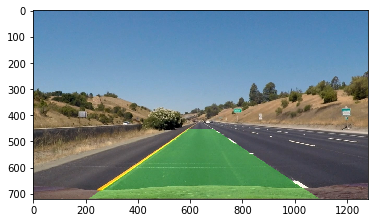

In [23]:
plt.imshow(transform_back(img, warpped_binary, left_fitx, right_fitx, ploty))

## Total pipeline

In [24]:
from collections import deque

left_fit_global = None
right_fit_global = None

memery_size = 10
memory_left = deque()
memory_right = deque()

def lane_finder(img):
    blurred = prepross_img(img)
    grad_binary = gradient_threshold(blurred)
    color_binary = color_threshold(blurred)
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(grad_binary == 1) | (color_binary == 1)] = 1
    warpped_binary = perspective_transform(combined_binary)
    
    global left_fit_global, right_fit_global
    if left_fit_global is None or right_fit_global is None:
        leftx, lefty, rightx, righty, out_img = lane_pixel_finder_histogram_and_sliding_window(warpped_binary)
    else:
        leftx, lefty, rightx, righty, out_img = lane_pixel_finder_priori(warpped_binary, left_fit_global, right_fit_global)

    memory_left.append(np.vstack((leftx, lefty)))
    memory_right.append(np.vstack((rightx, righty)))
    if len(memory_left) > memery_size:
        memory_left.popleft()
    if len(memory_right) > memery_size:
        memory_right.popleft()
        
    left_fit, left_fitx, right_fit, right_fitx, ploty = fit_second_order_lanes(warpped_binary.shape[0], np.hstack(memory_left)[0,:], np.hstack(memory_left)[1,:], np.hstack(memory_right)[0,:], np.hstack(memory_right)[1,:])
    
    minpix = 50
    # keep left_fit_global and right_fit_global updated only if non-zero pixels are greater than minpix
    if len(left_fitx) < minpix or len(right_fitx) < minpix:
        left_fit_global = None
        right_fit_global = None
    else:
        left_fit_global = left_fit
        right_fit_global = right_fit
        
    left_curvature = get_curvature(warpped_binary.shape[0], left_fit, xm_per_pix, ym_per_pix)
    right_curvature = get_curvature(warpped_binary.shape[0], right_fit, xm_per_pix, ym_per_pix)
    lat_offset = get_lat_offset(warpped_binary.shape[1], warpped_binary.shape[0], left_fit, right_fit, xm_per_pix)
        
    img_anotated = transform_back(img, warpped_binary, left_fitx, right_fitx, ploty)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 2
    cv2.putText(img_anotated,'Radius of curvature: {0:.3f} (m)'.format((left_curvature+right_curvature)/2), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)   
    bottomLeftCornerOfText = (50, 200)
    rel_to_lane_center = 'left' if lat_offset > 0 else 'right'
    cv2.putText(img_anotated,'Vehicle is {0:.3f}m '.format(lat_offset)+rel_to_lane_center+' to the center', 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)   
    
    return img_anotated 

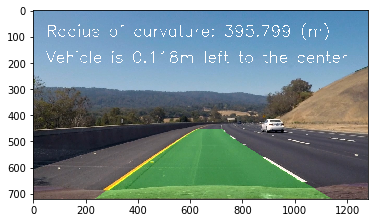

In [25]:
plt.imshow(lane_finder(curve_lane_img))
plt.imsave('../output_images/final/curved_lane_anotated.jpg',lane_finder(curve_lane_img))

## Video processing

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
video_output = '../output_images/videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("../project_video.mp4")
video_output_clip = video_clip.fl_image(lane_finder) #NOTE: this function expects color images!!
%time video_output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_images/videos/project_video.mp4
[MoviePy] Writing video ../output_images/videos/project_video.mp4


100%|█████████▉| 1260/1261 [05:23<00:00,  3.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/videos/project_video.mp4 

CPU times: user 5min 47s, sys: 54.2 s, total: 6min 42s
Wall time: 5min 24s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))